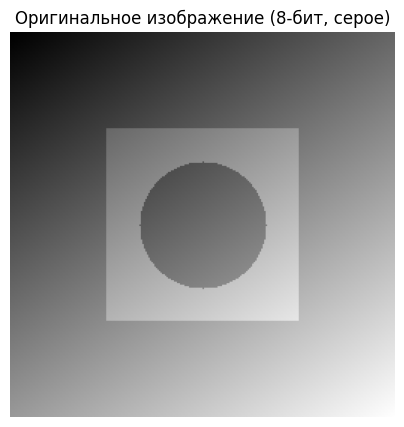

PNG сохранён: C:\Users\user\original_gray.png
Размер попиксельно (байт): 65536


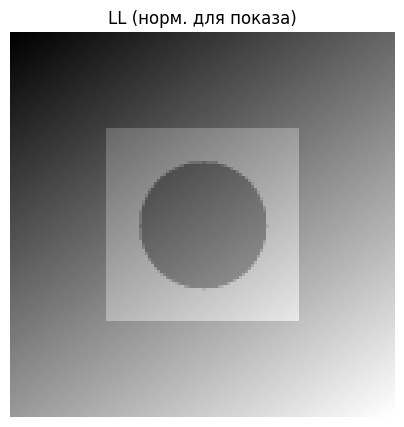

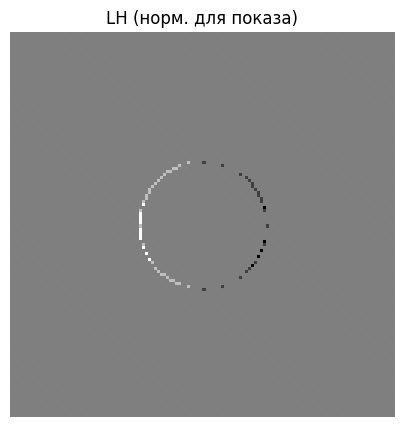

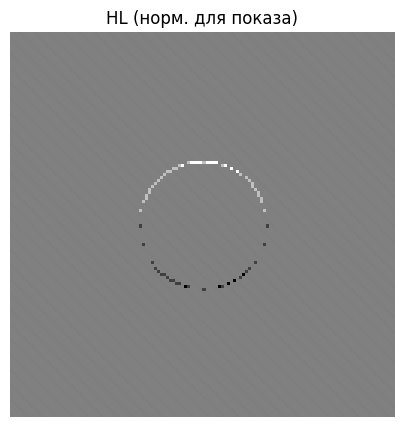

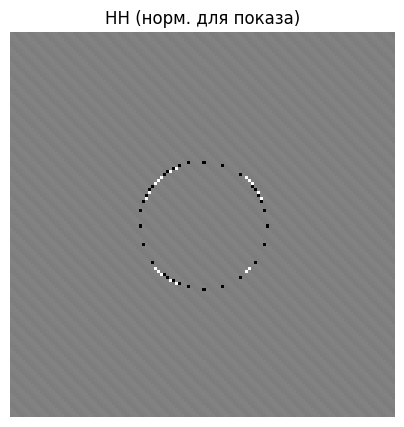

Текстовый файл: C:\Users\user\result_haar_rle.txt -> 221937 байт
Бинарный файл: C:\Users\user\result_haar_rle.bin -> 164986 байт
Объём попиксельного хранения (байт): 65536
Объём текстового представления (байт): 221937
Объём бинарного представления (байт): 164986

Коэффициент сжатия (orig / text): 0.29529100600620894
Коэффициент сжатия (orig / bin): 0.3972215824372977


In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ---------- 1D Хаар ----------
def haar_1d(x):
    # Пара вперёд Хаара: возвращает (суммы, разности)
    x = np.asarray(x, dtype=np.float32)
    assert x.size % 2 == 0, "Длина должна быть чётной для 1D Хаара"
    s = (x[0::2] + x[1::2]) / 2.0    # усреднение
    d = (x[0::2] - x[1::2]) / 2.0    # половина разности
    return s, d

# ---------- 2D Хаар (1 уровень) ----------
def haar_2d_level1(img):
    # Один уровень 2D-Хаара. img — 2D массив float32/float64.
    h, w = img.shape
    assert h % 2 == 0 and w % 2 == 0, "Высота и ширина должны быть чётными"
    # По строкам
    s_rows = np.zeros((h, w//2), dtype=np.float32)
    d_rows = np.zeros((h, w//2), dtype=np.float32)
    for i in range(h):
        s_rows[i], d_rows[i] = haar_1d(img[i])
    # По столбцам на s_rows и d_rows
    LL = np.zeros((h//2, w//2), dtype=np.float32)
    LH = np.zeros((h//2, w//2), dtype=np.float32)
    HL = np.zeros((h//2, w//2), dtype=np.float32)
    HH = np.zeros((h//2, w//2), dtype=np.float32)
    for j in range(w//2):
        s_col, d_col = haar_1d(s_rows[:, j])
        LL[:, j] = s_col
        HL[:, j] = d_col
        s_col2, d_col2 = haar_1d(d_rows[:, j])
        LH[:, j] = s_col2
        HH[:, j] = d_col2
    return LL, LH, HL, HH

# ---------- Квантование до N уровней ----------
def quantize_uniform(arr, levels=4):
    # Равномерное квантование массива arr на 'levels' уровней.
    a_min, a_max = float(np.min(arr)), float(np.max(arr))
    if a_min == a_max:
        return (np.full_like(arr, a_min, dtype=np.float32),
                np.array([a_min, a_max], dtype=np.float32),
                np.zeros_like(arr, dtype=np.int32))
    edges = np.linspace(a_min, a_max, levels+1, dtype=np.float32)
    centers = (edges[:-1] + edges[1:]) / 2.0
    codes = np.clip(np.digitize(arr, edges[1:-1], right=False), 0, levels-1)
    q = centers[codes]
    return q.astype(np.float32), edges, codes.astype(np.int32)

# ---------- RLE ----------
def rle_encode(arr_2d):
    # Кодируем построчно; возвращаем список (value, count)
    flat = arr_2d.flatten()
    if flat.size == 0:
        return []
    runs = []
    curr_val = flat[0]
    count = 1
    for v in flat[1:]:
        if v == curr_val:
            count += 1
        else:
            runs.append((int(curr_val), int(count)))
            curr_val = v
            count = 1
    runs.append((int(curr_val), int(count)))
    return runs

def rle_from_codes(codes_2d):
    # RLE по кодам (целые 0..L-1)
    return rle_encode(codes_2d.astype(np.int32))

# ---------- Сохранение представления ----------
def save_representation_text(basepath, LL, LH_codes, HL_codes, HH_codes, levels=4):
    # Текст: LL h w + числа; затем LH/HL/HH: Nruns + пары (value count)
    txt_path = basepath + "_haar_rle.txt"
    with open(txt_path, "w", encoding="utf-8") as f:
        h, w = LL.shape
        f.write(f"LL {h} {w}\n")
        flatLL = LL.flatten()
        f.write(" ".join(f"{x:.4f}" for x in flatLL) + "\n")
        for name, codes in [("LH", LH_codes), ("HL", HL_codes), ("HH", HH_codes)]:
            runs = rle_from_codes(codes)
            f.write(f"{name} {len(runs)}\n")
            line = " ".join(f"{int(v)} {int(c)}" for (v, c) in runs)
            f.write(line + "\n")
    return txt_path

def save_representation_binary(basepath, LL, LH_codes, HL_codes, HH_codes):
    # Бинарно: b'HAAR1' + int32 h,w + float32 LL +
    #          для каждого (int32 num_runs + num_runs*(int8 value,int32 count))
    import struct
    bin_path = basepath + "_haar_rle.bin"
    h, w = LL.shape
    with open(bin_path, "wb") as f:
        f.write(b"HAAR1")
        f.write(struct.pack("<ii", h, w))
        f.write(LL.astype(np.float32).tobytes(order="C"))
        for codes in [LH_codes, HL_codes, HH_codes]:
            runs = rle_from_codes(codes)
            f.write(struct.pack("<i", len(runs)))
            for v, c in runs:
                f.write(struct.pack("<bi", int(v), int(c)))
    return bin_path

def show_image(img2d, title):
    plt.figure(figsize=(5,5))
    plt.imshow(img2d, cmap="gray", vmin=0, vmax=255)
    plt.title(title)
    plt.axis("off")
    plt.show()

# ======== Демонстрация ========

# Укажите путь к своему изображению (или оставьте None для синтетики)
user_image_path = None  # например: "my_photo.png"

def load_or_make_image(path=None, target_size=(256,256)):
    if path is not None and os.path.exists(path):
        img = Image.open(path).convert("L")
        img = img.resize(target_size, Image.BILINEAR)
    else:
        h, w = target_size
        y = np.linspace(0, 255, h, dtype=np.float32).reshape(-1,1)
        x = np.linspace(0, 255, w, dtype=np.float32).reshape(1,-1)
        base = (0.6*y + 0.4*x) % 256
        img_arr = base.copy()
        img_arr[h//4:3*h//4, w//4:3*w//4] += 40
        cy, cx, r = h//2, w//2, min(h,w)//6
        Y, X = np.ogrid[:h, :w]
        mask = (Y-cy)**2 + (X-cx)**2 <= r*r
        img_arr[mask] -= 60
        img_arr = np.clip(img_arr, 0, 255)
        img = Image.fromarray(img_arr.astype(np.uint8))  # без mode="L"
    w, h = img.size
    if w % 2 == 1: w -= 1
    if h % 2 == 1: h -= 1
    img = img.crop((0,0,w,h))
    return img

# --- Подготовка и показ исходника
img = load_or_make_image(user_image_path, target_size=(256,256))
arr = np.array(img, dtype=np.uint8)

orig_path_png = "original_gray.png"
Image.fromarray(arr).save(orig_path_png)  # без mode="L"

show_image(arr, "Оригинальное изображение (8-бит, серое)")
print("PNG сохранён:", os.path.abspath(orig_path_png))
print("Размер попиксельно (байт):", arr.size)

# --- Преобразование Хаара и квантование
arr_f = arr.astype(np.float32)
LL, LH, HL, HH = haar_2d_level1(arr_f)

levels = 4
_, _, LH_codes = quantize_uniform(LH, levels=levels)
_, _, HL_codes = quantize_uniform(HL, levels=levels)
_, _, HH_codes = quantize_uniform(HH, levels=levels)

# Показ поддиапазонов (нормируем только для визуализации)
def norm_for_show(a):
    mn, mx = float(a.min()), float(a.max())
    if mx - mn < 1e-6:
        return np.zeros_like(a)
    return (a - mn) * (255.0 / (mx - mn))

show_image(norm_for_show(LL), "LL (норм. для показа)")
show_image(norm_for_show(LH), "LH (норм. для показа)")
show_image(norm_for_show(HL), "HL (норм. для показа)")
show_image(norm_for_show(HH), "HH (норм. для показа)")

# --- Сохранение результатов
base = "result"
txt_path = save_representation_text(base, LL, LH_codes, HL_codes, HH_codes, levels=levels)
bin_path = save_representation_binary(base, LL, LH_codes, HL_codes, HH_codes)

print("Текстовый файл:", os.path.abspath(txt_path), "->", os.path.getsize(txt_path), "байт")
print("Бинарный файл:", os.path.abspath(bin_path), "->", os.path.getsize(bin_path), "байт")

# --- Сравнение объёмов
orig_bytes = arr.size  # 1 байт на пиксель (8 бит)
txt_bytes = os.path.getsize(txt_path)
bin_bytes = os.path.getsize(bin_path)

print("Объём попиксельного хранения (байт):", orig_bytes)
print("Объём текстового представления (байт):", txt_bytes)
print("Объём бинарного представления (байт):", bin_bytes)

def ratio(a, b):
    return a / b if b != 0 else float('inf')

print("\nКоэффициент сжатия (orig / text):", ratio(orig_bytes, txt_bytes))
print("Коэффициент сжатия (orig / bin):", ratio(orig_bytes, bin_bytes))

